### Discontinuity metrics

The number of points is 279


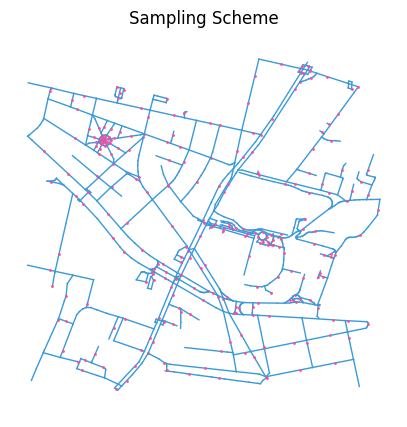

In [1]:
#Import the StreetSampler
from alivestreets.sampling.street_sampler import StreetSampler

n_points = 200
street_sampler = StreetSampler(n_points)
geojson_path = "data/network_2.geojson"

street_sampler.open_streets(geojson_path)
street_sampler.sample_streets_no_intersections()
street_sampler.draw_sampling_scheme(width = 5, height = 5)

print(f"The number of points is {len(street_sampler.get_all_sampling_points())}")

Let's tag the number of facades as an example

In [2]:
#Open the sampling point images data, which we downloaded in first_street_view_features.ipynb
import os
import json

path_points_dictionary = os.path.join(os.getcwd(),"data","network_images_demo", "point_dictionaries.jsonl")
points_data = []

with open(path_points_dictionary, "r") as f:
    for line in f:
        points_data.append(json.loads(line))



from alivestreets.features.facade_features import FacadeFeatureExtractor
from tqdm import tqdm
import cv2
import numpy as np


n_points = len(points_data)


#It's important to know and apply this dictionary. 
#I will also make it the default value in the future. 
class_dictionary = {
                "bench":0,
                "door":1,
                "facade":2,
                "graffiti":3,
                "person":4,
                "sidewalk":5,
                "signage":6,
                "sky":7,
                "street_light":8,
                "trash":9,
                "utility_pole":10,
                "vegetation":11,
                "vehicle":12,
                "window":13
            }

path_model = os.path.join(os.getcwd(), "model_facades.pt")

#Define the Facade feature extractor 
facade_feat_extractor = FacadeFeatureExtractor(
    #Code dyslexia
    model_path = path_model,
    facade_feature_id_dictionary = class_dictionary,
    threshold = 0.2
)





In [3]:
car_counts = []

feature_to_examine = "facade"
car_count_list = []
confidences_car_counts = []

for i in tqdm(range(0,len(points_data))):
    point_dictionary = points_data[i]
    view_paths = point_dictionary["view_paths"]

    car_counts = 0
    n_paths = len(view_paths)
    mean_confidence = 0
    for j in range(0,len(view_paths)):
        img = cv2.imread(view_paths[j])
        #By default the feature that is obtained is the number of instances in the image. I will show how to extract
        #other attributes like area of elements in the next cell. 

        results = facade_feat_extractor.compute([feature_to_examine], img, confidence_threshold = 0.2)
        count, confidences = results[feature_to_examine]
        car_counts += count
        if(len(confidences) > 0):
            mean_confidence += np.mean(confidences)
    if(n_paths>0):
        mean_confidence = mean_confidence/n_paths

    car_count_list.append(car_counts)
    confidences_car_counts.append(mean_confidence)

100%|██████████| 279/279 [05:39<00:00,  1.22s/it]


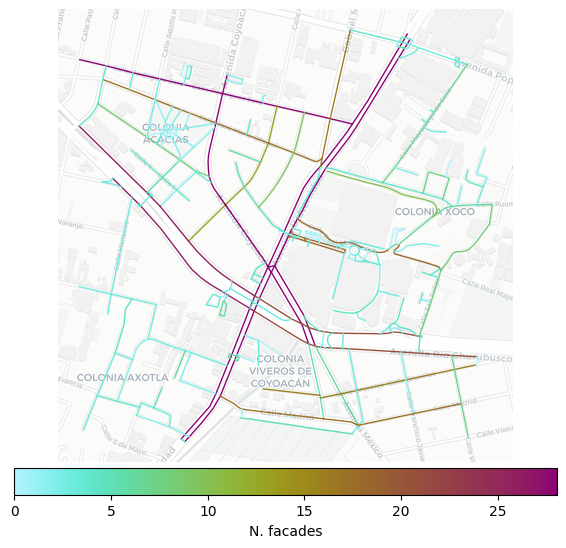

In [4]:
from alivestreets.visualization.map_visualizer import MapVisualizer
import cmcrameri.cm as cm
#Great, now you tag the GVI just like every other feature.
street_sampler.tag_streets(
    "N. facades", 
    car_count_list,
    method = "sum"
)

#I recently added an option to use a cmap so let's use a color blind friendly one
cmap = cm.hawaii_r

vis = MapVisualizer()
vis.initialize_map(figsize = (7,7))

vis.add_street_sampler(street_sampler, 
"N. facades", 
variable_type="continuous",
edge_width = 1,
cmap = cmap)
vis.draw_networks(colorbar_label = "N. facades", colorbar_orientation = "horizontal", min_percentile=1, max_percentile=99)
vis.add_basemap(alpha = 0.7)
vis.finalize_map()

In [5]:
from alivestreets.network.graph_utilities import build_graph_from_sampler, attach_sampler_street_attributes_to_graph, attach_sampler_segment_attributes_to_graph
from alivestreets.visualization.trajectory_visualizer import plot_trajectory_on_graph, plot_attribute_time_series
import networkx as nx
import matplotlib.pyplot as plt

graph = build_graph_from_sampler(street_sampler)
undirected_graph = graph.to_undirected()

# Attach attribute
attach_sampler_segment_attributes_to_graph(
    undirected_graph, 
    street_sampler, 
    "N. facades", 
    aggregation="sum", 
)


In [6]:
from alivestreets.network import network_retrieval, osm_features
from alivestreets.sampling.street_sampler import StreetSampler
import geopandas as gpd
import alivestreets as ast

lat = 19.36132786021484
lon = -99.17086000273748
radius = 600

features_path = os.path.join(os.getcwd(), "data", "features_2")
osm_features.export_all_from_point(
    features_path,
    lat, 
    lon,
    radius
)



Exported /Users/juanlegaria/Library/CloudStorage/OneDrive-InstitutoTecnologicoydeEstudiosSuperioresdeMonterrey/CFC/alivestreets/alivestreets/tests/data/features_2/parks.geojson
Exported /Users/juanlegaria/Library/CloudStorage/OneDrive-InstitutoTecnologicoydeEstudiosSuperioresdeMonterrey/CFC/alivestreets/alivestreets/tests/data/features_2/amenities.geojson
Exported /Users/juanlegaria/Library/CloudStorage/OneDrive-InstitutoTecnologicoydeEstudiosSuperioresdeMonterrey/CFC/alivestreets/alivestreets/tests/data/features_2/bus_stops.geojson
Exported /Users/juanlegaria/Library/CloudStorage/OneDrive-InstitutoTecnologicoydeEstudiosSuperioresdeMonterrey/CFC/alivestreets/alivestreets/tests/data/features_2/schools.geojson
Exported /Users/juanlegaria/Library/CloudStorage/OneDrive-InstitutoTecnologicoydeEstudiosSuperioresdeMonterrey/CFC/alivestreets/alivestreets/tests/data/features_2/job_centers.geojson
Exported /Users/juanlegaria/Library/CloudStorage/OneDrive-InstitutoTecnologicoydeEstudiosSuperiores

In [7]:
# Load GeoJSONs
gdf_subway = gpd.read_file("data/features_2/subway.geojson")
gdf_amenities = gpd.read_file("data/features_2/amenities.geojson")

# Filter to point geometries only
gdf_subway = gdf_subway[gdf_subway.geometry.geom_type == "Point"]
gdf_amenities = gdf_amenities[gdf_amenities.geometry.geom_type == "Point"]

# Extract coordinates as (lon, lat) tuples
subway_points = [(geom.x, geom.y) for geom in gdf_subway.geometry]
amenity_points = [(geom.x, geom.y) for geom in gdf_amenities.geometry]


#The discontinuity analysis will focus on trajectories going from subways to amenities. 
from alivestreets.path_analysis.path_discontinuity_analysis import assign_edge_discontinuity

assign_edge_discontinuity(
    undirected_graph,
    subway_points,
    amenity_points,
    "N. facades"
)

100%|██████████| 1/1 [00:00<00:00,  3.27it/s]


In [8]:
from alivestreets.network.graph_utilities import attach_edge_attribute_to_sampler

attach_edge_attribute_to_sampler(
    undirected_graph,
    street_sampler,
    edge_attribute = "discontinuity", 
    street_attribute = "discontinuity_facades",
    
)

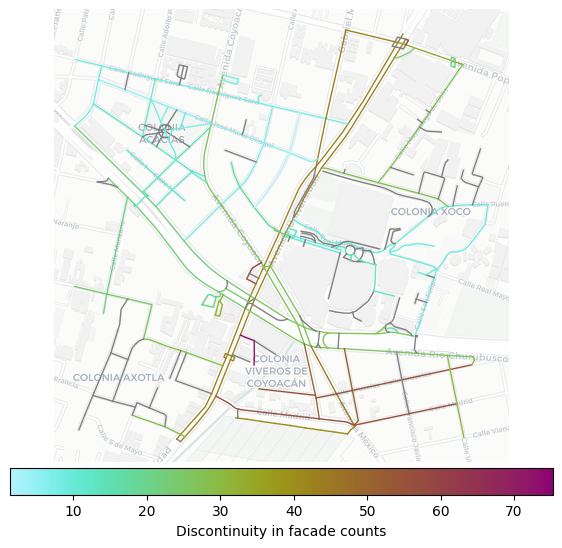

In [11]:
from alivestreets.visualization.map_visualizer import MapVisualizer

vis = MapVisualizer()
vis.initialize_map(figsize = (7,7))

vis.add_street_sampler(street_sampler, 
"discontinuity_facades", 
variable_type="continuous",
edge_width = 1,cmap = cmap)
vis.draw_networks(colorbar_label = "Discontinuity in facade counts", colorbar_orientation = "horizontal")
vis.add_basemap(alpha = 0.7)
vis.finalize_map()